In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import Callable
from collections import defaultdict
from scipy.spatial.distance import cosine

from flash_ansr import get_path
from flash_ansr import SkeletonPool, FlashANSRTransformer, NoValidSampleFoundError
from flash_ansr.expressions.utils import codify, num_to_constants

import omegaconf
from nesymres.architectures.model import Model as NeSymReSModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def ezip(*iterables):
    return ((index, items) for index, items in enumerate(zip(*iterables)))

In [3]:
pool = SkeletonPool.from_config(get_path('configs', 'v7.0', 'skeleton_pool_train.yaml'))
pool.sample_strategy['max_tries'] = 100

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 23462.65it/s]


In [4]:
MODELS = {
    'v7.3': FlashANSRTransformer.load(get_path('models', 'ansr-models', 'v7.3'))[1].to(device),
    'v7.0': FlashANSRTransformer.load(get_path('models', 'ansr-models', 'v7.0'))[1].to(device),
    'v8.0': FlashANSRTransformer.load(get_path('models', 'ansr-models', 'v8.0'))[1].to(device),
}

In [5]:
nesymres =  NeSymReSModel.load_from_checkpoint(
    get_path('models', 'nesymres', '100M.ckpt'),
    cfg=omegaconf.OmegaConf.load(get_path('configs', 'nesymres-100M', 'config.yaml')).architecture
).eval().to(device)

/home/psaegert/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../models/nesymres/100M.ckpt`


In [6]:
ENCODERS = {
    'nesymres': lambda x: nesymres.enc(x).flatten(),
    'v7.3': lambda x: MODELS['v7.0'].encoder(MODELS['v7.3'].pre_encoder(x))[0].flatten(),
    'v7.0': lambda x: MODELS['v7.0'].encoder(MODELS['v7.0'].pre_encoder(x))[0].flatten(),
    'v8.0': lambda x: MODELS['v8.0'].encoder(MODELS['v8.0'].pre_encoder(x))[0].flatten(),
}

In [7]:
ENCODERS_NAMES = {
    'nesymres': 'NeSymReS-100M',
    'v7.3': 'v7.3',
    'v7.0': 'v7.0',
    'v8.0': 'v8.0',
}

In [8]:
N_SUPPORT = 128

In [9]:
def support_prior(size: tuple[int]) -> np.ndarray:
    return np.concatenate([np.random.uniform(-10, 10, size=(size[0], 1)) for j in range(size[1])], axis=1).astype(np.float32)

In [10]:
pool.sample_strategy['independent_dimensions'] = False
x_base = np.concatenate([support_prior(size=(N_SUPPORT, 1)) for _ in range(len(pool.expression_space.variables))], axis=1).astype(np.float32)
pool.sample_strategy['independent_dimensions'] = True

In [11]:
def get_embeddings_for_skeleton(encoders: dict[str, Callable], skeleton: list[str], x: np.ndarray, skeleton_pool: SkeletonPool, n_embeddings: int = 100, n_support: int = 512, same_interval: bool = False, verbose: bool = False) -> np.ndarray:
    executable_prefix_expression = skeleton_pool.expression_space.operators_to_realizations(skeleton)
    prefix_expression_with_constants, constants = num_to_constants(executable_prefix_expression)
    code_string = skeleton_pool.expression_space.prefix_to_infix(prefix_expression_with_constants, realization=True)
    code = codify(code_string, skeleton_pool.expression_space.variables + constants)

    embeddings_dict = defaultdict(list)

    skeleton_pool.sample_strategy['independent_dimensions'] = False

    if same_interval:
        x = x.reshape(-1, len(skeleton_pool.expression_space.variables))

        # Determine the bounds of the x data (unbiased estimators)
        a = x.min(0) - (x.max(0) - x.min(0)) / x.shape[0]
        b = x.max(0) + (x.max(0) - x.min(0)) / x.shape[0]

        # Sample in the same interval as the original data
        def support_prior(size: tuple[int]) -> np.ndarray:
            return np.concatenate([np.random.uniform(a[j], b[j], size=(size[0], 1)) for j in range(size[1])], axis=1).astype(np.float32)

    for _ in tqdm(range(n_embeddings), disable=not verbose):
        X, Y, _ = skeleton_pool.sample_data(code, len(constants), n_support, support_prior=support_prior if same_interval else None)

        # Set all x that do not appear in the expression to 0
        for i, variable in enumerate(skeleton_pool.expression_space.variables):
            if variable not in skeleton:
                X[:, i] = 0

        data_tensor = torch.tensor(np.concatenate([X, Y], axis=1), device=device).unsqueeze(0)

        # pre_encodings = flash_ansr_transformer.pre_encoder(data_tensor)
        # memory = flash_ansr_transformer.encoder(pre_encodings)[0].flatten()

        for model_name, encoder in encoders.items():
            embeddings_dict[model_name].append(encoder(data_tensor).detach().cpu().numpy())

    for model_name in embeddings_dict:
        embeddings_dict[model_name] = np.stack(embeddings_dict[model_name])
    
    skeleton_pool.sample_strategy['independent_dimensions'] = True

    return dict(embeddings_dict)

In [12]:
skeleton = ['+', '+', '*', 'sin', 'x1', '<num>', '*', 'cos', 'x2', '<num>', '<num>']

# Random Intervals

In [13]:
embeddings = get_embeddings_for_skeleton(ENCODERS, skeleton, x_base, pool, n_embeddings=64, n_support=x_base.shape[0], verbose=True)

100%|██████████| 64/64 [00:01<00:00, 39.55it/s]


In [14]:
pairwise_cosine_similarities = {}

for model_name in embeddings:
    pairwise_cosine_similarities[model_name] = np.zeros((embeddings[model_name].shape[0], embeddings[model_name].shape[0]))

    for i in range(embeddings[model_name].shape[0]):
        for j in range(i):
            pairwise_cosine_similarities[model_name][i, j] = 1 - cosine(embeddings[model_name][i], embeddings[model_name][j])
            pairwise_cosine_similarities[model_name][j, i] = pairwise_cosine_similarities[model_name][i, j]

    # Diagonal is 1
    np.fill_diagonal(pairwise_cosine_similarities[model_name], 1)

# Sort the pairwise cosine similarities
sorted_pairwise_cosine_similarities = {}
sorted_indices = np.argsort(pairwise_cosine_similarities['v7.0'].mean(0))[::-1]
for model_name in pairwise_cosine_similarities:
    sorted_pairwise_cosine_similarities[model_name] = pairwise_cosine_similarities[model_name][sorted_indices][:, sorted_indices]

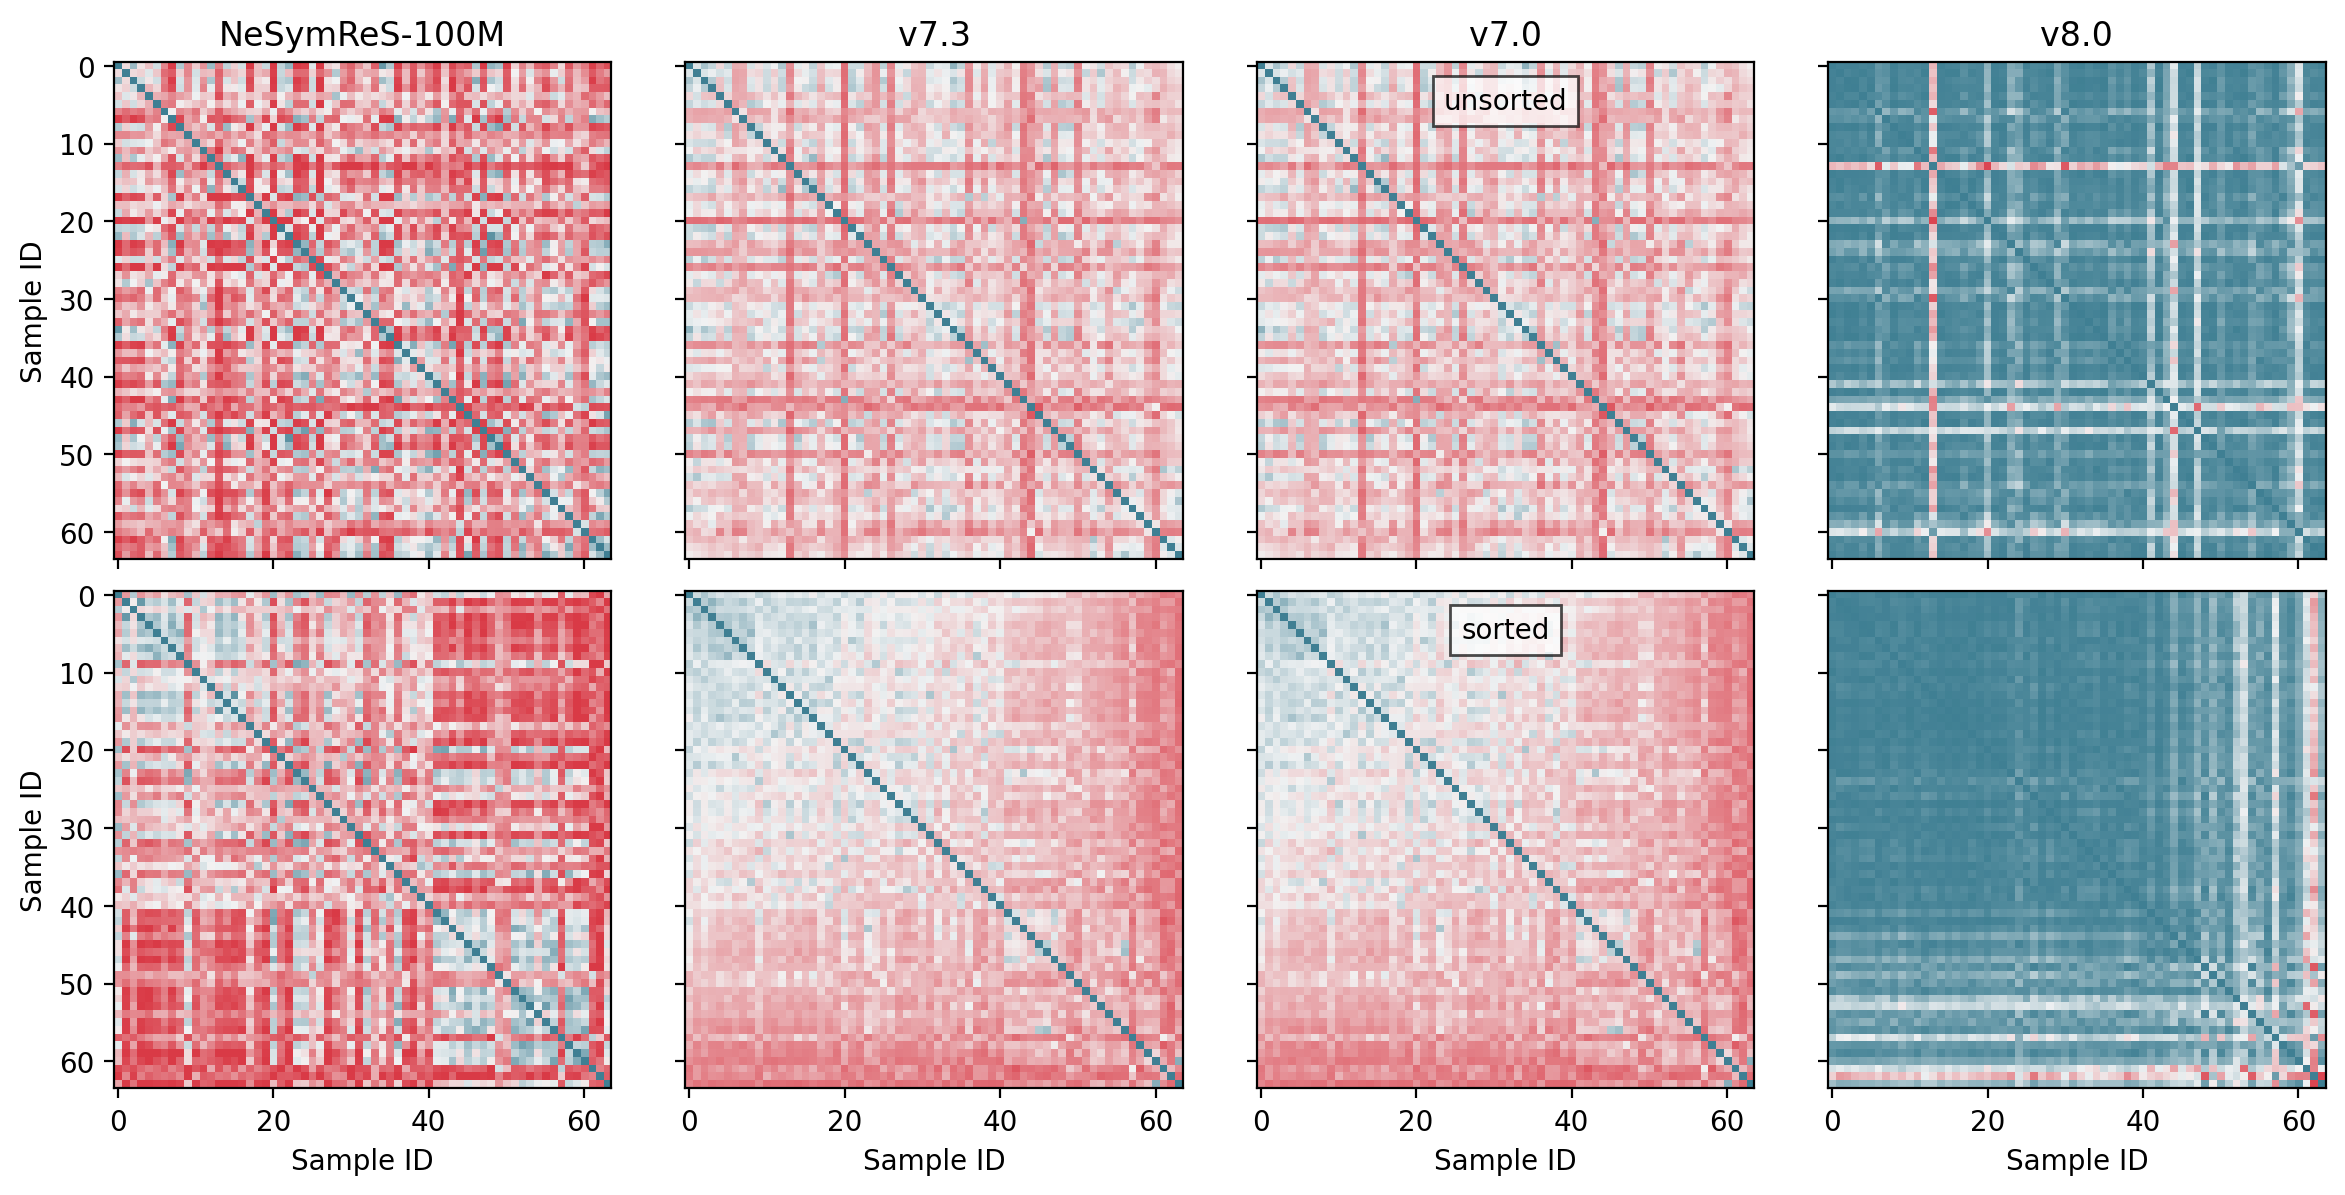

In [15]:
COLS = len(embeddings)
ROWS = 2

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3), sharex=True, sharey=True, dpi=200)

for i, (axes_row, similarities, annotation) in ezip(axes, [pairwise_cosine_similarities, sorted_pairwise_cosine_similarities], ['unsorted', 'sorted']):
    for j, (ax, (model, embedding)) in ezip(axes_row, embeddings.items()):
        # axes[i].imshow(pairwise_cosine_similarities[model], vmin=0, vmax=1, cmap=plt.get_cmap('seismic'))
        ax.imshow(1 - similarities[model], vmin=0, vmax=1, cmap=sns.diverging_palette(220, 10, as_cmap=True), rasterized=True)
        if i == 0:
            ax.set_title(f'{ENCODERS_NAMES[model]}')
        elif i == 1:
            ax.set_xlabel('Sample ID')

        if j == 0:
            ax.set_ylabel('Sample ID')

        if j == 2:
            ax.annotate(annotation, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


fig.tight_layout()

plt.savefig(get_path('results', 'T-JSL', create=True, filename=f'tjsl_pairwise_cosine_similarities_random_intervals.png'))

# Same Interval

In [16]:
embeddings = get_embeddings_for_skeleton(ENCODERS, skeleton, x_base, pool, n_embeddings=64, n_support=x_base.shape[0], same_interval=True, verbose=True)

100%|██████████| 64/64 [00:01<00:00, 46.55it/s]


In [17]:
pairwise_cosine_similarities = {}

for model_name in embeddings:
    pairwise_cosine_similarities[model_name] = np.zeros((embeddings[model_name].shape[0], embeddings[model_name].shape[0]))

    for i in range(embeddings[model_name].shape[0]):
        for j in range(i):
            pairwise_cosine_similarities[model_name][i, j] = 1 - cosine(embeddings[model_name][i], embeddings[model_name][j])
            pairwise_cosine_similarities[model_name][j, i] = pairwise_cosine_similarities[model_name][i, j]

    # Diagonal is 1
    np.fill_diagonal(pairwise_cosine_similarities[model_name], 1)

# Sort the pairwise cosine similarities
sorted_pairwise_cosine_similarities = {}
sorted_indices = np.argsort(pairwise_cosine_similarities['v7.0'].mean(0))[::-1]
for model_name in pairwise_cosine_similarities:
    sorted_pairwise_cosine_similarities[model_name] = pairwise_cosine_similarities[model_name][sorted_indices][:, sorted_indices]

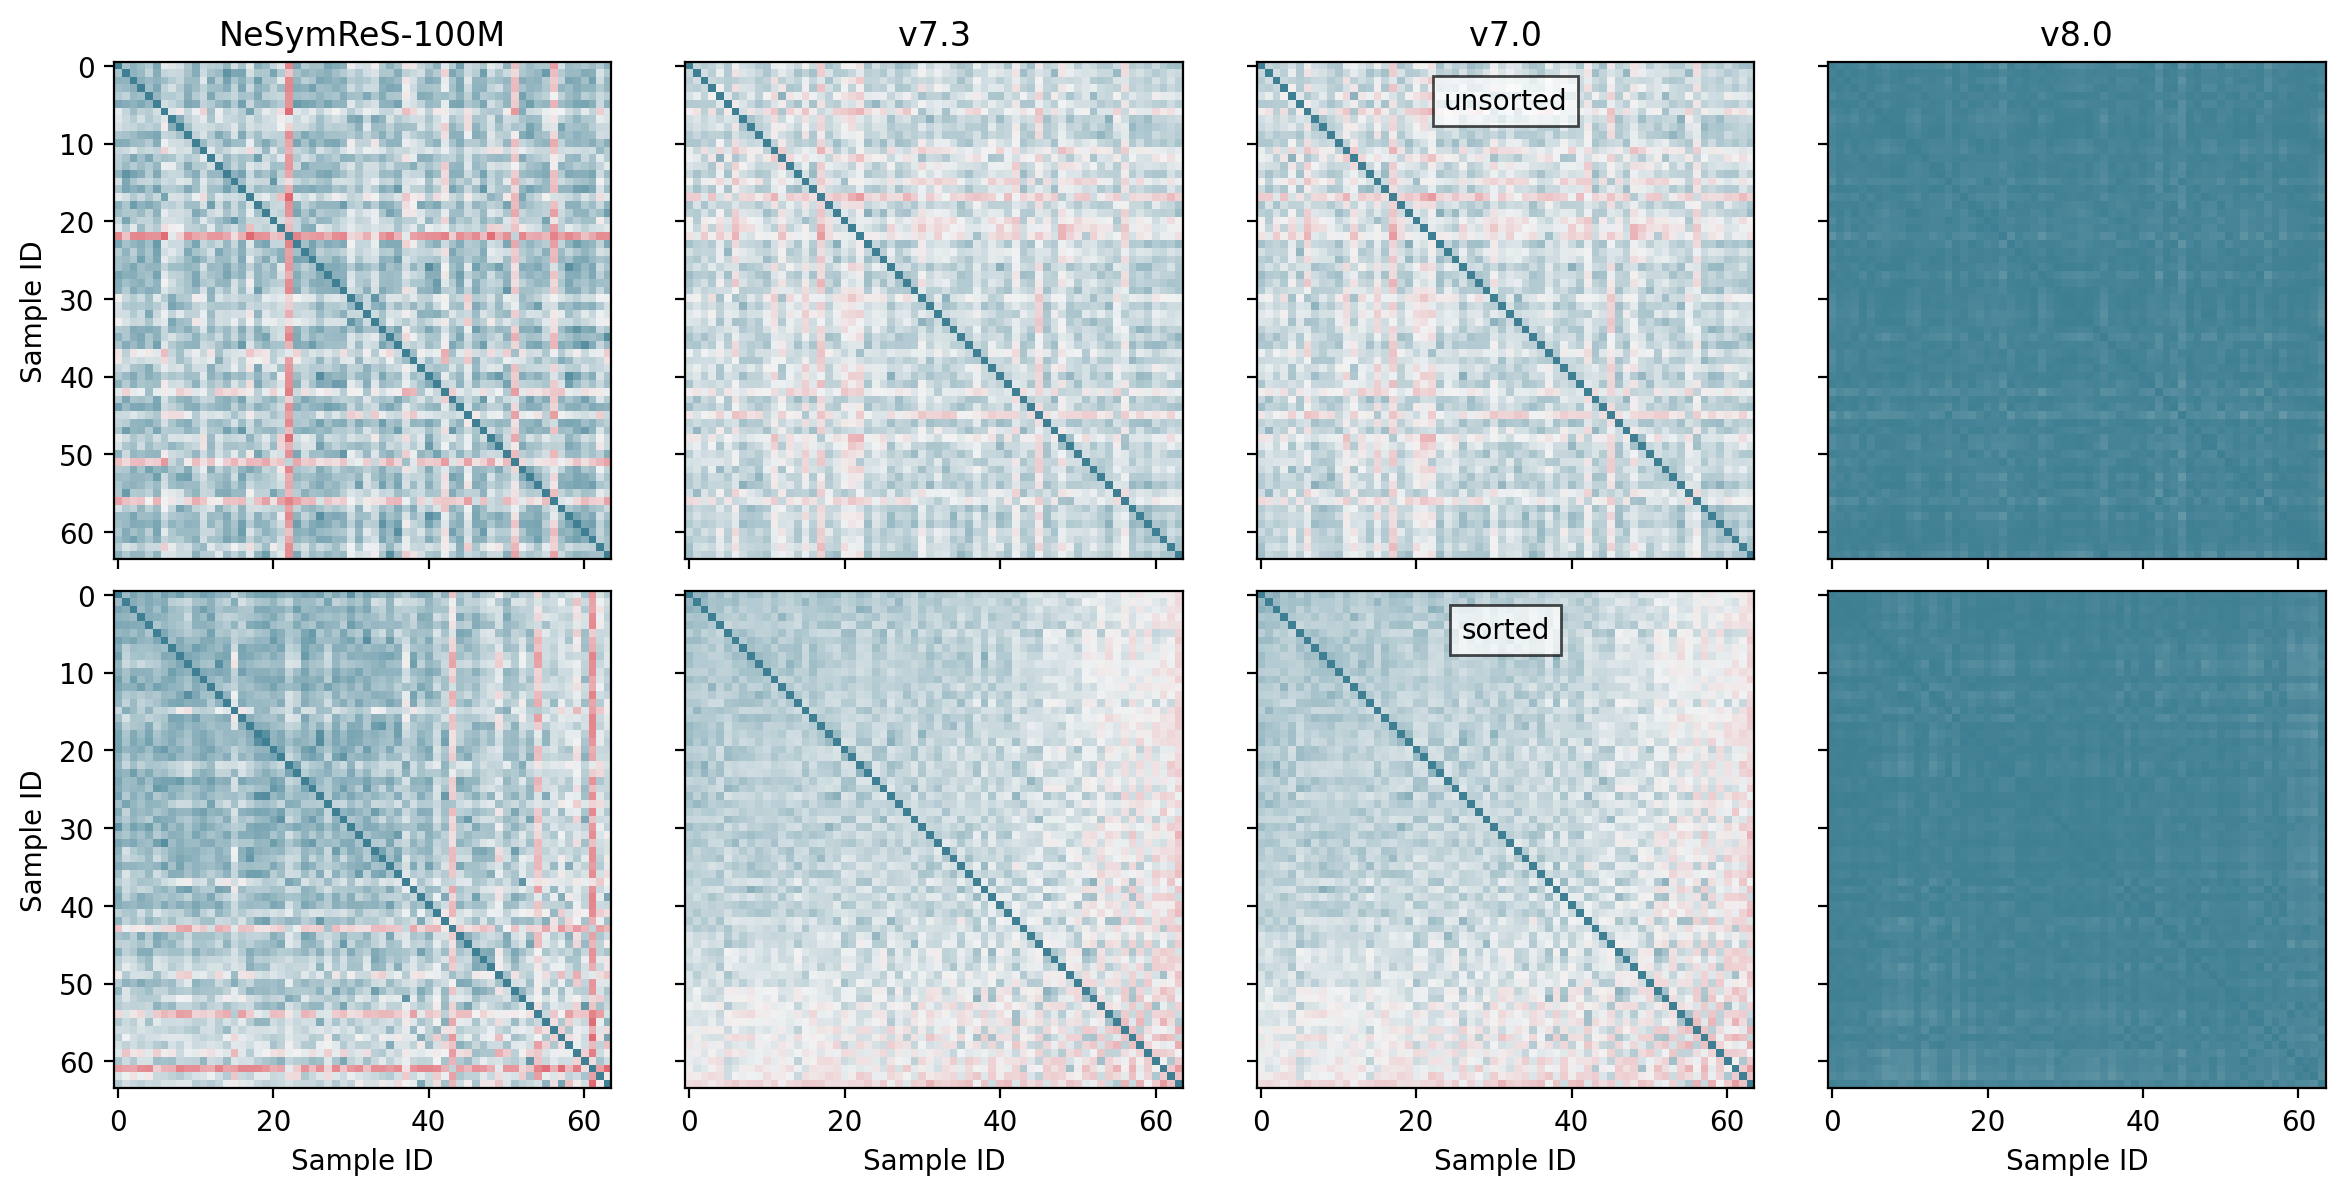

In [18]:
COLS = len(embeddings)
ROWS = 2

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3), sharex=True, sharey=True, dpi=200)

for i, (axes_row, similarities, annotation) in ezip(axes, [pairwise_cosine_similarities, sorted_pairwise_cosine_similarities], ['unsorted', 'sorted']):
    for j, (ax, (model, embedding)) in ezip(axes_row, embeddings.items()):
        # axes[i].imshow(pairwise_cosine_similarities[model], vmin=0, vmax=1, cmap=plt.get_cmap('seismic'))
        ax.imshow(1 - similarities[model], vmin=0, vmax=1, cmap=sns.diverging_palette(220, 10, as_cmap=True), rasterized=True)
        if i == 0:
            ax.set_title(f'{ENCODERS_NAMES[model]}')
        elif i == 1:
            ax.set_xlabel('Sample ID')

        if j == 0:
            ax.set_ylabel('Sample ID')

        if j == 2:
            ax.annotate(annotation, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


fig.tight_layout()

plt.savefig(get_path('results', 'T-JSL', create=True, filename=f'tjsl_pairwise_cosine_similarities_same_intervals.png'))